# Plotting Training and testing

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gym
import matplotlib.pyplot as plt
import matplotlib as mpl
from collections import defaultdict
import os, sys
root = os.getcwd()
sys.path.append(root)
sys.path.append('..')

import matplotlib as mpl
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['font.size'] = 8
# mpl.rcParams['font.family'] = 'serif'
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

import utils.plot_utils as pltu
from logger import *
from utils.plot_utils import *
from plot_functions import *
from configs import *
from models.model_lstm import *
# import tasks.generative_1d
from tasks.hierarchical_gaussians_task import *
from train import *
# from plot_functions import plot_behavior_novel_contexts, plot_histograms_novel_contexts
# from plot_functions import plot_combined_behavior_and_histograms
from plot_functions import *

default_mean1 = 0.3
default_mean2 = 0.7
default_std = 0.1
default_std_novel = 0.2
means = np.array(list(range(-2, 13)))/10
stds = [0.1, 0.2, 0.3, 0.4, 0.5]


# Cortex RNN

Create simple training plot

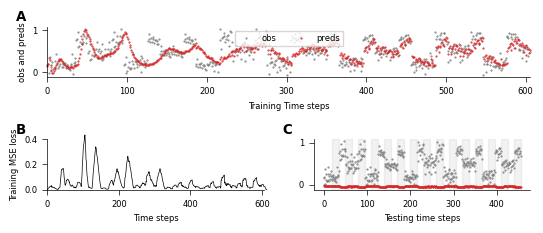

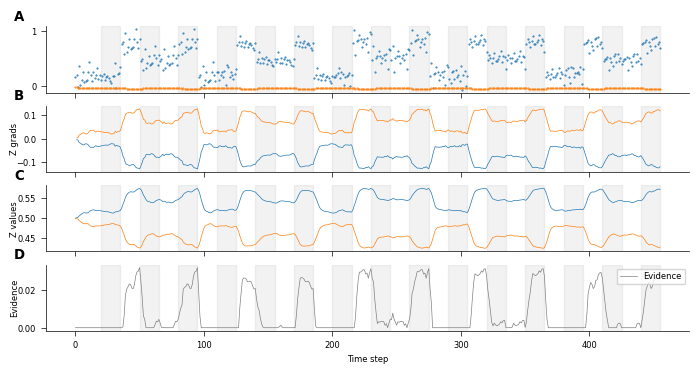

In [26]:
# Train RNN
config = Config()
config.default_std = default_std
scale = 3
training_phase_1_config = {'context_transition_function':'two_sequences',
        'max_trials_per_block':int(scale*5), 'min_trials_per_block':int(scale*2),
        'context_switch_rate': 1/(scale*(5-3)), 'no_of_blocks':40}
config.training_phases= [{'start_ts': 1, 'config': training_phase_1_config}]
logger = Logger(config)
env = Generative_environment(config, experiment=7)
model = LSTM_model(config,hidden_size=100)
weights = [p for n,p in model.named_parameters() if n !='thalamus']
# weights = weights + [model.get_parameter('thalamus')]
WU_optimizer = optim.Adam(weights, lr=0.001)
ts_in_training= 0
# horizon = training_phase_1_config['max_trials_per_block'] * (1+1+1)
horizon = 5
_use_oracle = False
# memory_buffer, losses = adapt_model_v2(model, env, _use_oracle, config, WU_optimizer, horizon, nn.MSELoss(), ts_in_training, logger)
# plot_behavior(memory_buffer, env, losses, config, _use_oracle )


# Testing and plotting
config.training_phases[0]['config']['no_of_blocks'] = 30
testing_env = Generative_environment(config, experiment=7)

# horizon = 5
optimizer = torch.optim.SGD([model.get_parameter('thalamus')], lr=.30, momentum=0.5)
logger = Logger(config)
criterion = nn.MSELoss(reduction='sum')
_use_oracle = False
_use_optimized_thalamus = False
testing_memory_buffer, testing_losses = adapt_model_v2(model, testing_env, _use_oracle, config, optimizer, horizon, criterion,
                                                ts_in_training, logger, _use_optimized_thalamus=_use_optimized_thalamus)
                                       
plot_behavior_simple(memory_buffer, env, losses, config, _use_oracle, testing_memory_buffer, testing_env)
plot_grads(testing_memory_buffer, testing_env, x1=50, x2=np.inf)
# plt.savefig(f'./exports/Cortex_only_CL_behavior.pdf')

Text(0.5, 0, 'Trials')

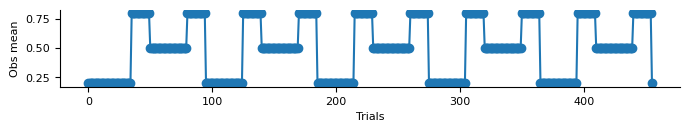

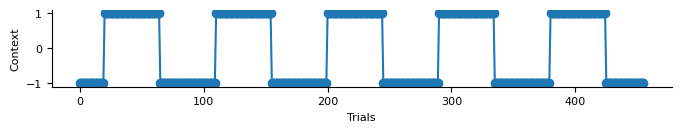

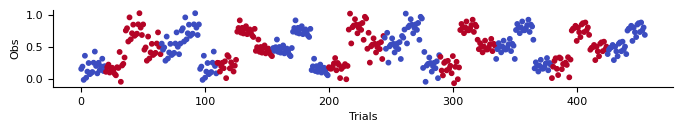

In [27]:
# get the obs from the memory buffer
obs = testing_memory_buffer.timestep_data['obs']
obs = np.array(obs)

env_key = testing_memory_buffer.timestep_data['context_names']
means = []
for env_key in testing_memory_buffer.timestep_data['context_names']:
    mean = testing_env.envs[env_key]['kwargs']['mean']
    means.append(mean)
means = np.array(means)

# create a wide and short subplots and plot the means
fig, ax = plt.subplots(1,1, figsize=(8,1))
ax.plot(means, 'o-')
ax.set_ylabel('Obs mean')
ax.set_xlabel('Trials')

# now plot the signal corresponding to the high level context
fig, ax = plt.subplots(1,1, figsize=(8,1))

                # sequence_position = self.block_i % (len(self.seq2) +len(self.seq2))
                # self.current_context = f'gauss{sequence_position}'
max_trials = config.training_phases[0]['config']['max_trials_per_block']

context2 = np.zeros(len(obs))
# context2 is 1 for indices from 0 to 3*max_trials trials and the -1 from 3*max_trials trials to 6*max_trials trials and so on
for i in range(len(context2)):
    if i//(3*max_trials) % 2 == 0:
        context2[i] = 1
    else:
        context2[i] = -1
# the very first block is a special case, choosen always to be 20 and does not belong to any of the two sequences
# append 20 -1s to the beginning of the context2 and then remove the last 20 elements
context2 = np.concatenate([np.ones(20)*-1, context2])
context2 = context2[:-20]
# now plot the context2
ax.plot(context2, 'o-')
ax.set_ylabel('Context')
ax.set_xlabel('Trials')

# now plot observations colored by context:
fig, ax = plt.subplots(1,1, figsize=(8,1))
ax.scatter(np.arange(len(obs)), obs, c=context2, cmap='coolwarm', s=10)
ax.set_ylabel('Obs')
ax.set_xlabel('Trials')


In [28]:
# now get the gradients from the memory buffer
grads = np.stack(testing_memory_buffer.timestep_data['thalamus_grad'])
grads = grads.squeeze()[:, 0] # take only one unit grads

grads.shape

(456,)

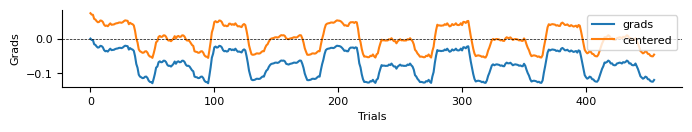

In [29]:
grads[0] = 0 # first value is padded with a nan
centered_grads = grads - np.mean(grads)

# plot grads and centered_grads 
fig, ax = plt.subplots(1,1, figsize=(8,1))
ax.plot(grads, label='grads')
ax.plot(centered_grads, label='centered')
ax.axhline(0, color='k', linestyle='--', linewidth=0.5)
ax.set_ylabel('Grads')
ax.set_xlabel('Trials')
ax.legend()



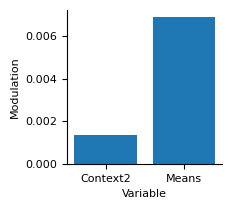

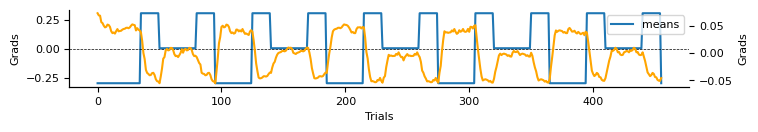

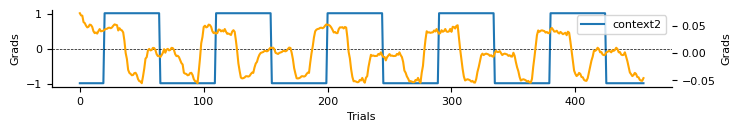

In [30]:
# Now that I have the grads in a vector, I want to check their modulation by context2 array vs means array, using something similar to the analysis below:

centered_grads = grads - np.mean(grads)
centered_means = means-np.mean(means)
grads_modulation_by_context2 = np.dot(context2-np.mean(context2), centered_grads)/ len(context2) # 
grads_modulation_by_context2 = np.abs(grads_modulation_by_context2)

grads_modulation_by_means = np.dot(centered_means, centered_grads)/ len(means) #
grads_modulation_by_means = np.abs(grads_modulation_by_means)

# bar plot the modulation
fig, ax = plt.subplots(1,1, figsize=(2,2))
ax.bar([0,1], [grads_modulation_by_context2, grads_modulation_by_means])
ax.set_xticks([0,1])
ax.set_xticklabels(['Context2', 'Means'])
ax.set_ylabel('Modulation')
ax.set_xlabel('Variable')

# plot centered grads overlaid on centered means
fig, ax = plt.subplots(1,1, figsize=(8,1))
# ax.plot(centered_grads, label='grads')
ax.plot(centered_means, label='means')
# centered_grads have a very different scale, plot them on a second axis
ax2 = ax.twinx()
ax2.plot(centered_grads, label='grads', color='orange')
ax2.set_ylabel('Grads')
ax2.spines['right'].set_color('orange')
ax.axhline(0, color='k', linestyle='--', linewidth=0.5)
ax.set_ylabel('Grads')
ax.set_xlabel('Trials')
ax.legend()

# plot centered grads overlaid on centered context2
fig, ax = plt.subplots(1,1, figsize=(8,1))
# ax.plot(centered_grads, label='grads')
ax.plot(context2-np.mean(context2), label='context2')
# centered_grads have a very different scale, plot them on a second axis
ax2 = ax.twinx()
ax2.plot(centered_grads, label='grads', color='orange')
ax2.set_ylabel('Grads')
ax2.spines['right'].set_color('orange')

ax.axhline(0, color='k', linestyle='--', linewidth=0.5)
ax.set_ylabel('Grads')
ax.set_xlabel('Trials')
ax.legend()


#### Train RNN Cortex+MD  (THe only difference from the above case is Oracle is True)


env_id is larger than thalamus size, setting it to thalamus size-1


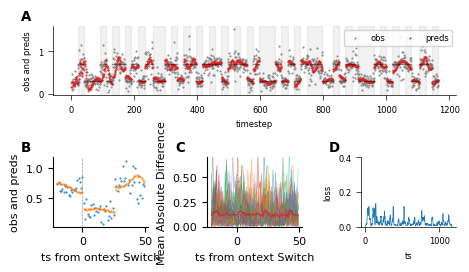

In [8]:
# config = Config(env_kwargs= { 'gauss1': {'mean': default_mean1, 'std': default_std}, 'gauss2': {'mean': default_mean2, 'std': default_std},})
config = generalization_mean_and_var_Config (env_kwargs= { 'gauss1': {'mean': default_mean1, 'std': 0.1},
                'gauss2': {'mean': default_mean2, 'std': 0.1}, 'gauss3': {'mean': default_mean1, 'std': 0.2},
                 'gauss3': {'mean': default_mean2, 'std': 0.2}}, context_units=2)

scale = 10
training_phase_1_config = {'context_transition_function':'geometric',
        'max_trials_per_block':int(scale*5), 'min_trials_per_block':int(scale*2),
        'context_switch_rate': 1/(scale*(5-3)), 'no_of_blocks':50}
config.training_phases= [{'start_ts': 1, 'config': training_phase_1_config}]
logger = Logger(config)
env = Generative_environment(config)
model = LSTM_model(config,hidden_size=100)
WU_optimizer = optim.Adam(model.parameters(), lr=0.001)
ts_in_training= 0
horizon = 5

_use_oracle = True
memory_buffer, losses = adapt_model_v2(model, env, _use_oracle, config, WU_optimizer, horizon, nn.MSELoss(), ts_in_training, logger)
plot_behavior(memory_buffer, env, losses, config, _use_oracle )

env_id is larger than thalamus size, setting it to thalamus size-1


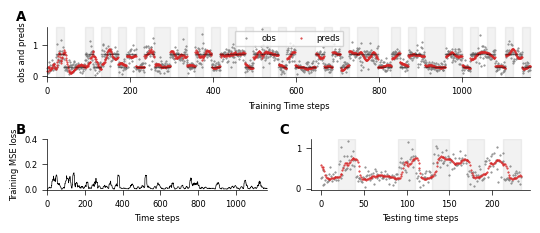

In [9]:
# Testing and plotting
config.training_phases[0]['config']['no_of_blocks'] = 10
testing_env = Generative_environment(config, adapt_env=1)
horizon = 5
optimizer = torch.optim.SGD([model.get_parameter('thalamus')], lr=.30, momentum=0.5)
logger = Logger(config)
criterion = nn.MSELoss(reduction='sum')
_use_oracle = False
_use_optimized_thalamus = True
testing_memory_buffer, testing_losses = adapt_model_v2(model, testing_env, _use_oracle, config, optimizer, horizon, criterion,
                                                ts_in_training, logger, _use_optimized_thalamus=_use_optimized_thalamus)
                                       
plot_behavior_simple(memory_buffer, env, losses, config, _use_oracle, testing_memory_buffer, testing_env)
# plt.savefig(f'./exports/Cortex_MD_CXT_CL_behavior.pdf')
